In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import time as time
import csv

In [2]:
train_days = 260 * 7
train_hours = train_days * 24
test_hours = 24 * 7 * 8

In [3]:
T = 24
u_max = 10
Q = 50
q_0 = Q / 2

In [4]:
repeat_times = 10

# load forecast signals and samples

In [5]:
forecast_signals = np.load("data/forecast_signals.npy")

In [6]:
price_data = np.load("data/price_data.npy")

In [7]:
scenario_samples = np.load("data/scenario_samples.npy")

# Incremental Proximal Algorithm

In [8]:
def generate_subp(q_t, t, minibatch_size, u_max, Q):
    u_var = cp.Variable()
    z_var = cp.Variable((T - 1, minibatch_size))
    p_param = cp.Parameter((T - 1, minibatch_size), nonneg=True)
    one_over_c_k = cp.Parameter(nonneg=True)
    u_prev = cp.Parameter()
    
    linear = price_data[t] * u_var + cp.sum(cp.multiply(p_param, z_var), axis=0)
    ell_one = price_data[t] * cp.abs(u_var) + cp.sum(cp.multiply(p_param, cp.abs(z_var)), axis=0)
        
    cost = cp.sum(linear + 0.075 * ell_one) / minibatch_size
        
    constr = [cp.abs(u_var) <= u_max, cp.abs(z_var) <= u_max, 
              q_t + u_var >= 0, q_t + u_var <= Q,
              q_t + u_var + cp.cumsum(z_var, axis=0) >= 0,
              q_t + u_var + cp.cumsum(z_var, axis=0) <= Q,
              q_t + u_var + cp.sum(z_var, axis=0) == Q / 2]
    
    subp = cp.Problem(cp.Minimize(cost + 0.5 * one_over_c_k * cp.sum_squares(u_var - u_prev)), constr)
    
    return subp, u_var, p_param, one_over_c_k, u_prev

In [9]:
def generate_subp_dpp(q_t, t, minibatch_size, u_max, Q):
    u_var = cp.Variable()
    z_var = cp.Variable((T - 1, minibatch_size))
    p_param = cp.Parameter((T - 1, minibatch_size), nonneg=True)
    one_over_sqrt_c_k = cp.Parameter(nonneg=True)
    u_prev_over_sqrt_c_k = cp.Parameter()
    
    linear = price_data[t] * u_var + cp.sum(cp.multiply(p_param, z_var), axis=0)
    ell_one = price_data[t] * cp.abs(u_var) + cp.sum(cp.multiply(p_param, cp.abs(z_var)), axis=0)
        
    cost = cp.sum(linear + 0.075 * ell_one) / minibatch_size
        
    constr = [cp.abs(u_var) <= u_max, cp.abs(z_var) <= u_max, 
              q_t + u_var >= 0, q_t + u_var <= Q,
              q_t + u_var + cp.cumsum(z_var, axis=0) >= 0,
              q_t + u_var + cp.cumsum(z_var, axis=0) <= Q,
              q_t + u_var + cp.sum(z_var, axis=0) == Q / 2]
    
    prox_term = 0.5 * cp.sum_squares(one_over_sqrt_c_k * u_var - u_prev_over_sqrt_c_k)
    
    subp = cp.Problem(cp.Minimize(cost + prox_term), constr)
    
    return subp, u_var, p_param, one_over_sqrt_c_k, u_prev_over_sqrt_c_k

In [10]:
def MPC(t, q_t, forecast, u_max, Q, solver):
    
    subp, u_var, p_param, one_over_c_k, u_prev = generate_subp(q_t, t, 1, u_max, Q)
    
    p_param.value = forecast.reshape((T - 1, 1))
    one_over_c_k.value = 0
    u_prev.value = 0
    
    subp.solve(solver=solver)

    return u_var.value

In [11]:
def incre_prox_alg(t, q_t, price, forecast, u_max, Q, c=1, init_val=0, max_iter=None, minibatch_size=1, 
                   verbose=False, use_MPC_init=True, no_prox=False, solver="ECOS"):
    time0 = time.time()
    _, n_samples = price.shape
    minibatch_size = min(minibatch_size, n_samples)
    
    if max_iter is None:
        max_iter = n_samples // minibatch_size
        
    if use_MPC_init:
        u_k = MPC(t, q_t, forecast, u_max, Q, solver)
    else:
        u_k = init_val
    
    if (not no_prox) and max_iter > 1:
        subp, u_var, p_param, one_over_sqrt_c_k_param, u_prev_over_sqrt_c_k_param = \
        generate_subp_dpp(q_t, t, minibatch_size, u_max, Q)
    else:
        subp, u_var, p_param, one_over_c_k, u_prev = generate_subp(q_t, t, minibatch_size, u_max, Q)
    
    minibatch_num = n_samples // minibatch_size
    
    for iter_idx in range(0, max_iter):
        minibatch_idx = iter_idx % minibatch_num
        sample_idxs = np.arange(minibatch_idx * minibatch_size, (minibatch_idx + 1) * minibatch_size)
        p_param.value = price[:, sample_idxs]
        
        if no_prox:
            one_over_c_k.value = 0
            u_prev.value = 0
        else:
            if max_iter > 1:
                one_over_sqrt_c_k_param.value = np.power((iter_idx + 1) / c, 0.5)
                u_prev_over_sqrt_c_k_param.value = u_k * np.power((iter_idx + 1) / c, 0.5)
            else:
                one_over_c_k.value = np.power((iter_idx + 1) / c, 0.5)
                u_prev.value = u_k
                    
        update_success = True
#         try:
        subp.solve(solver=solver)
#         except:
#             print(subp.status)
#             update_success = False
        
        if verbose:
            print("iter =", iter_idx, "u =", u_var.value,
                  "incre =", np.linalg.norm(u_var.value - u_k), 
                  "time elapsed =", time.time() - time0)
        
        if update_success:
            if np.linalg.norm(u_var.value - u_k) <= 1e-18:
                break
            u_k = u_var.value
    
    return u_k

In [12]:
def eval_policy(u):
    linear = price_data[train_hours: train_hours + len(u)].dot(u)
    quad = np.sum(np.square(u))
    ell_one = price_data[train_hours: train_hours + len(u)].dot(np.abs(u))
    return (linear + 0.075 * ell_one) / len(u)

# run single-forecast MPC

In [13]:
q_t = q_0
u_MPC = np.zeros(test_hours)
t_begin = time.time()
for t in range(train_hours, train_hours + test_hours):
    hour_idx = t - train_hours
    # forecast
    forecast_signal = forecast_signals[:, hour_idx]
    forecast_price = np.exp(np.exp(forecast_signal))

    # set q_t
    if hour_idx > 0:
        q_t += u_MPC[hour_idx - 1]
        
    # call MPC solver
    u_MPC[hour_idx] = incre_prox_alg(t, q_t, np.zeros((T - 1, 1)), forecast_price, u_max, Q, 
                                     max_iter=0, use_MPC_init=True)
    
    if hour_idx % 24 == 23:
        print("test hour", hour_idx, "test day", hour_idx // 24, 
              "cost ", eval_policy(u_MPC[0: hour_idx + 1]),
              "time elasped ", time.time() - t_begin)

policy_eval_MPC = eval_policy(u_MPC)
print("MPC policy cost =", policy_eval_MPC, "runtime =", time.time() - t_begin)

/Users/xinyueshen/anaconda3/lib/python3.7/site-packages/cvxpy/reductions/solvers/solving_chain.py:167: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


test hour 23 test day 0 cost  -43.39900614566381 time elasped  0.6419529914855957
test hour 47 test day 1 cost  -32.13999786338962 time elasped  1.2272069454193115
test hour 71 test day 2 cost  -29.39384974935797 time elasped  1.83821702003479
test hour 95 test day 3 cost  -47.890139701389906 time elasped  2.432157039642334
test hour 119 test day 4 cost  -55.086748973085236 time elasped  3.0310940742492676
test hour 143 test day 5 cost  -50.71085567443943 time elasped  3.599168062210083
test hour 167 test day 6 cost  -44.95112411499803 time elasped  4.156747102737427
test hour 191 test day 7 cost  -42.46472275710579 time elasped  4.711137056350708
test hour 215 test day 8 cost  -39.150422932138085 time elasped  5.261708974838257
test hour 239 test day 9 cost  -39.06235284805228 time elasped  5.844763994216919
test hour 263 test day 10 cost  -39.903951629850674 time elasped  6.401930093765259
test hour 287 test day 11 cost  -40.01665329980018 time elasped  6.992063045501709
test hour 31

# run MF-MPC

In [16]:
batch_sizes = np.array([1, 2, 4, 8, 16, 32]) * 20
u_MFMPC = np.zeros((repeat_times, test_hours, len(batch_sizes)))
time_MFMPC = np.zeros((repeat_times, len(batch_sizes)))

In [18]:
for repeat_idx in range(repeat_times):
    print("repeat idx", repeat_idx)
    for batch_size_idx in range(0, len(batch_sizes)):
        batch_size = batch_sizes[batch_size_idx]
        print("  batch size", batch_size)
        q_t = q_0

        t_begin = time.time()

        for t in range(train_hours, train_hours + test_hours):
            hour_idx = t - train_hours
            # forecast
            forecast_signal = forecast_signals[:, hour_idx]
            forecast_price = np.exp(np.exp(forecast_signal))
    
            forecast_error_normal_samples = scenario_samples[repeat_idx, t % (24 * 7), 0: batch_size, :]
            normal_samples = np.exp(np.exp(forecast_signal[None, :] + forecast_error_normal_samples).T)

            # set q_t
            if hour_idx > 0:
                q_t += u_MFMPC[repeat_idx, hour_idx - 1, batch_size_idx]   
                    
            # call solver
            u_MFMPC[repeat_idx, hour_idx, batch_size_idx] = incre_prox_alg(t, q_t, normal_samples, 
                                                                           forecast_price, u_max, Q, 
                                                                           max_iter=1, use_MPC_init=False, 
                                                                           no_prox=True, 
                                                                           minibatch_size=batch_size)
    
            if hour_idx % (24 * 7) == 24 * 7 - 1:
                print("    test hour", hour_idx, "test day", hour_idx // 24, 
                      "    cost", eval_policy(u_MFMPC[repeat_idx, 0: hour_idx + 1, batch_size_idx]), 
                      "    time elasped =", time.time() - t_begin)

        policy_eval_batch = eval_policy(u_MFMPC[repeat_idx, :, batch_size_idx])
        time_MFMPC[repeat_idx, batch_size_idx] = time.time() - t_begin
        print("  batch size idx", batch_size_idx, "batch policy cost =", policy_eval_batch, 
              "runtime =", time.time() - t_begin)

repeat idx 0
  batch size 20
    test hour 167 test day 6     cost -51.36061079024113     time elasped = 7.437010049819946
    test hour 335 test day 13     cost -41.162727369675814     time elasped = 14.961335182189941
    test hour 503 test day 20     cost -40.35727149040167     time elasped = 22.415571928024292
    test hour 671 test day 27     cost -39.938410886655056     time elasped = 29.652409076690674
    test hour 839 test day 34     cost -41.14281501574102     time elasped = 36.84928488731384
    test hour 1007 test day 41     cost -39.63379586578742     time elasped = 44.2187819480896
    test hour 1175 test day 48     cost -39.27407929359386     time elasped = 51.76264190673828
    test hour 1343 test day 55     cost -37.73885365126168     time elasped = 59.2085919380188
  batch size idx 0 batch policy cost = -37.73885365126168 runtime = 59.20899677276611


# run IP-MPC

In [19]:
max_iters = [1, 2, 4, 8, 16, 32]
u_IP = np.zeros((repeat_times, test_hours, len(batch_sizes)))
time_IP = np.zeros((repeat_times, len(batch_sizes)))

In [20]:
for repeat_idx in range(repeat_times):
    print("repeat idx", repeat_idx)
    for max_iter_idx in range(len(max_iters)):
        max_iter = max_iters[max_iter_idx]
        print("  max iter =", max_iter)
        q_t = q_0
        t_begin = time.time()
        for t in range(train_hours, train_hours + test_hours):
            hour_idx = t - train_hours
            # forecast
            forecast_signal = forecast_signals[:, hour_idx]
            forecast_price = np.exp(np.exp(forecast_signal))

            forecast_error_normal_samples = scenario_samples[repeat_idx, t % (24 * 7), 0: 20 * max_iter, :]
            normal_samples = np.exp(np.exp(forecast_signal[None, :] + forecast_error_normal_samples).T)
        
            # set q_tau
            if hour_idx > 0:
                q_t += u_IP[repeat_idx, hour_idx - 1, max_iter_idx]    
        
            # call IP-MPC solver
            u_IP[repeat_idx, hour_idx, max_iter_idx] = incre_prox_alg(t, q_t, normal_samples, forecast_price, 
                                                                      u_max, Q, c=7, max_iter=max_iter, 
                                                                      use_MPC_init=True, minibatch_size=20, 
                                                                      verbose=False)
        
            if hour_idx % (24 * 7) == 24 * 7 - 1:
                print("    test hour", hour_idx, "  test day", hour_idx // 24, 
                      "  cost", eval_policy(u_IP[repeat_idx, 0: hour_idx + 1, max_iter_idx]),
                      "  time elasped", time.time() - t_begin)

        time_IP[repeat_idx, max_iter_idx] = time.time() - t_begin
        print("  max iter =", max_iter, " policy cost =", eval_policy(u_IP[repeat_idx, :, max_iter_idx]), 
              "runtime =", time.time() - t_begin)

repeat idx 0
  max iter = 1
    test hour 167   test day 6   cost -50.11431427962799   time elasped 11.385034084320068
    test hour 335   test day 13   cost -40.49897372730418   time elasped 22.71253204345703
    test hour 503   test day 20   cost -40.56319878880604   time elasped 34.58987283706665
    test hour 671   test day 27   cost -41.02637751734757   time elasped 46.35398197174072
    test hour 839   test day 34   cost -42.88239395924212   time elasped 57.881818771362305
    test hour 1007   test day 41   cost -41.234320063433735   time elasped 69.34014797210693
    test hour 1175   test day 48   cost -40.67190006765642   time elasped 80.7897458076477
    test hour 1343   test day 55   cost -38.824500060571175   time elasped 92.2362790107727
  max iter = 1  policy cost = -38.824500060571175 runtime = 92.23652577400208


# plot result

In [17]:
u_IP = np.load("results/u_IP.npy")
u_MFMPC = np.load("results/u_MFMPC.npy")

In [18]:
policy_eval_IP = np.zeros((repeat_times, len(batch_sizes)))
for repeat_idx in range(repeat_times):
    for batch_size_idx in range(0, len(batch_sizes)):
        policy_eval_IP[repeat_idx, batch_size_idx] = eval_policy(u_IP[repeat_idx, :, batch_size_idx])

In [19]:
policy_eval_MFMPC = np.zeros((repeat_times, len(batch_sizes)))
for repeat_idx in range(repeat_times):
    for batch_size_idx in range(0, len(batch_sizes)):
        policy_eval_MFMPC[repeat_idx, batch_size_idx] = eval_policy(u_MFMPC[repeat_idx, :, batch_size_idx])

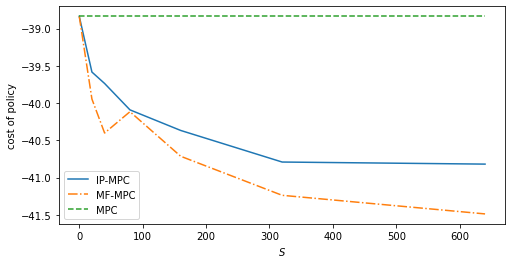

In [20]:
plt.figure(figsize=(8, 4))

plt.plot([0] + list(batch_sizes), [policy_eval_MPC] + list(np.mean(policy_eval_IP, axis=0)), label="IP-MPC")       
plt.plot([0] + list(batch_sizes), [policy_eval_MPC] + list(np.mean(policy_eval_MFMPC, axis=0)), "-.", label="MF-MPC")
plt.plot([0] + list(batch_sizes), policy_eval_MPC * np.ones(len(batch_sizes) + 1), "--", label="MPC")

plt.xlabel(r"$S$")
plt.ylabel("cost of policy")
plt.legend()

# plt.savefig("policy_cost_8weeks_10repeats.pdf")